**Homework 2. Vectorizers**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")


In [9]:
df_spam = pd.read_csv('datasets/spam_or_not_spam.csv')
df_spam.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [10]:
df_spam.label.value_counts()

label
0    2500
1     500
Name: count, dtype: int64

Очистка

In [ ]:
!python -m spacy download en_core_web_sm

In [7]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

In [13]:
%%time
df_spam['email'] = df_spam['email'].astype(str)
df_spam['cleaned_text'] = df_spam['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
df_spam.sample(5)

CPU times: user 1min 55s, sys: 4.38 s, total: 1min 59s
Wall time: 1min 59s


,email,label,cleaned_text
1817,forwarded by rob windsor windsor warthog com ...,0,forward rob windsor windsor warthog com forwar...
2534,요즘 뜨는 직종 best NUMBER 금융 it 방송 뷰티 인테리어 NUMBER대...,1,요즘 뜨는 직종 good number 금융 방송 뷰티 인테리어 number대 젊은이...
55,gordon rutter gordon URL join the fortean boo...,0,gordon rutter gordon url join fortean book rev...
2394,url URL date NUMBER NUMBER NUMBERtNUMBER NUMBE...,0,url url date number number numbertnumber numbe...
879,on NUMBER NUMBER NUMBER NUMBER NUMBER pm mr fo...,0,number number number number number pm mr fork ...


Векторизация

In [18]:
X = df_spam['cleaned_text']
y = df_spam['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
count_vectorizer = CountVectorizer(max_df=0.7, min_df=0.003)
tfidf_vectorizer = TfidfVectorizer()


X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [32]:
X_train_count, X_train_tfidf

(<2400x3423 sparse matrix of type '<class 'numpy.int64'>'
 	with 134319 stored elements in Compressed Sparse Row format>,
 <2400x25235 sparse matrix of type '<class 'numpy.float64'>'
 	with 178010 stored elements in Compressed Sparse Row format>)

In [47]:
X_test_count, X_test_tfidf

(<600x3423 sparse matrix of type '<class 'numpy.int64'>'
 	with 37067 stored elements in Compressed Sparse Row format>,
 <600x25235 sparse matrix of type '<class 'numpy.float64'>'
 	with 46782 stored elements in Compressed Sparse Row format>)

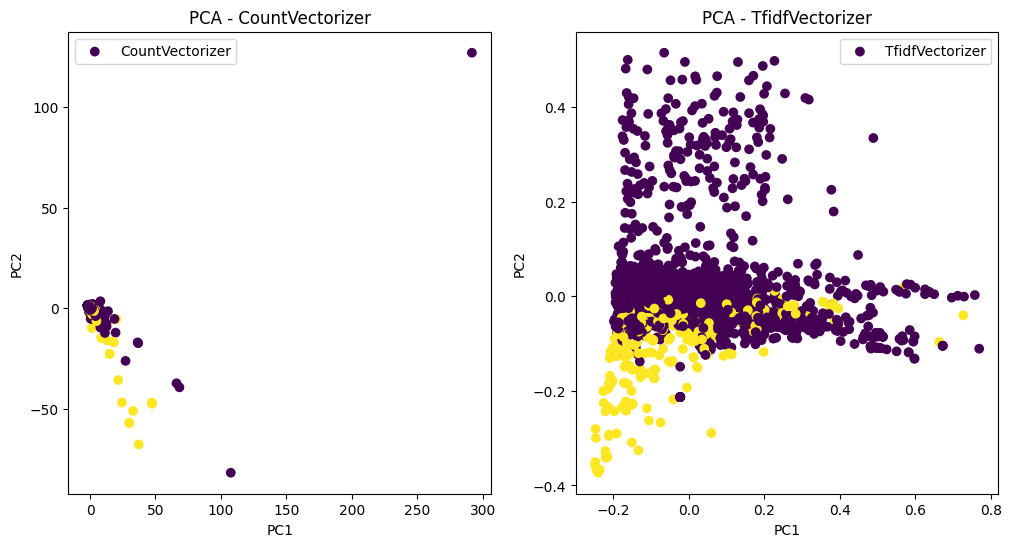

In [44]:
def plot_pca(X, y, title, ax, label):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X.toarray())
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', label=label)
    ax.set_title(title)
    ax.set_xlabel("PC1")  # Подпись для оси x
    ax.set_ylabel("PC2")  # Подпись для оси y

# Создайте общий график с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Постройте PCA для CountVectorizer
plot_pca(X_train_count, y_train, "PCA - CountVectorizer", axes[0], label="CountVectorizer")

# Постройте PCA для TfidfVectorizer
plot_pca(X_train_tfidf, y_train, "PCA - TfidfVectorizer", axes[1], label="TfidfVectorizer")

# Добавьте легенду
axes[0].legend()
axes[1].legend()

# Отобразите графики
plt.show()


Обучение моделей для CountVetorizer

In [59]:
def custom_tokenize(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text.split()


In [60]:
param_grid_decision_tree = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'counter__max_df': np.linspace(0.3, 0.7, 10),
    'counter__min_df': [0.0, 0.001, 0.003, 0.005],
    'counter__ngram_range': [(1, 1), (1, 2)]
}

param_grid_logistic_regression = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'counter__max_df': np.linspace(0.3, 0.7, 10),
    'counter__min_df': [0.0, 0.001, 0.003, 0.005],
    'counter__ngram_range': [(1, 1), (1, 2)]
}

param_grid_naive_bayes = {
    'classifier__alpha': [0.1, 0.5, 1.0],
    'counter__max_df': np.linspace(0.3, 0.7, 10),
    'counter__min_df': [0.0, 0.001, 0.003, 0.005],
    'counter__ngram_range': [(1, 1), (1, 2)]
}

In [61]:
pipeline_decision_tree = Pipeline([
    ('counter', CountVectorizer(tokenizer=custom_tokenize)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline_logistic_regression = Pipeline([
    ('counter', CountVectorizer(tokenizer=custom_tokenize)),
    ('classifier', LogisticRegression(random_state=42))
])

pipeline_naive_bayes = Pipeline([
    ('counter', CountVectorizer(tokenizer=custom_tokenize)),
    ('classifier', MultinomialNB())
])

In [62]:
halving_search_decision_tree = HalvingGridSearchCV(pipeline_decision_tree, param_grid_decision_tree, cv=2, scoring='accuracy')
halving_search_logistic_regression = HalvingGridSearchCV(pipeline_logistic_regression, param_grid_logistic_regression, cv=2, scoring='accuracy')
halving_search_naive_bayes = HalvingGridSearchCV(pipeline_naive_bayes, param_grid_naive_bayes, cv=2, scoring='accuracy')

In [ ]:
halving_search_decision_tree.fit(X_train, y_train)
halving_search_logistic_regression.fit(X_train, y_train)
halving_search_naive_bayes.fit(X_train, y_train)

In [66]:
best_score_decision_tree = halving_search_decision_tree.best_score_
best_score_logistic_regression = halving_search_logistic_regression.best_score_
best_score_naive_bayes = halving_search_naive_bayes.best_score_


print("Best Score with Countvectorizer for Decision Tree:", best_score_decision_tree)
print("Best Score with Countvectorizer for Logistic Regression:", best_score_logistic_regression)
print("Best Score with Countvectorizer for Naive Bayes:", best_score_naive_bayes)

Best Score with Countvectorizer for Decision Tree: 0.9506172839506173
Best Score with Countvectorizer for Logistic Regression: 0.9867337602927722
Best Score with Countvectorizer for Naive Bayes: 0.9863713798977853


In [67]:
best_params_decision_tree = halving_search_decision_tree.best_params_
best_params_logistic_regression = halving_search_logistic_regression.best_params_
best_params_naive_bayes = halving_search_naive_bayes.best_params_


print("Best Score with Countvectorizer for Decision Tree:", best_params_decision_tree)
print("Best Score with Countvectorizer for Logistic Regression:", best_params_logistic_regression)
print("Best Score with Countvectorizer for Naive Bayes:", best_params_naive_bayes)

Best Score with Countvectorizer for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'counter__max_df': 0.4333333333333333, 'counter__min_df': 0.003, 'counter__ngram_range': (1, 2)}
Best Score with Countvectorizer for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'counter__max_df': 0.611111111111111, 'counter__min_df': 0.003, 'counter__ngram_range': (1, 1)}
Best Score with Countvectorizer for Naive Bayes: {'classifier__alpha': 0.5, 'counter__max_df': 0.3, 'counter__min_df': 0.003, 'counter__ngram_range': (1, 2)}


In [68]:
best_decision_tree = halving_search_decision_tree.best_estimator_
best_logistic_regression = halving_search_logistic_regression.best_estimator_
best_naive_bayes = halving_search_naive_bayes.best_estimator_

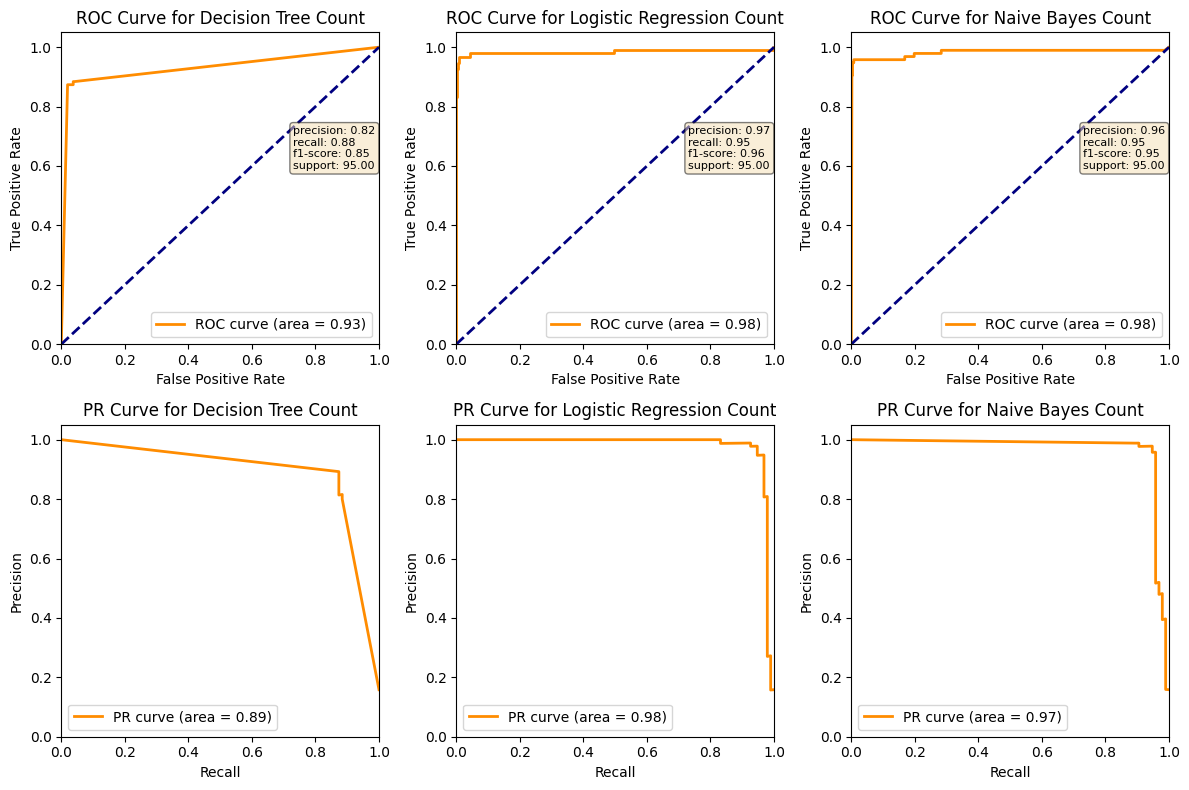

In [80]:
def plot_roc_pr_curves(model, X_test, y_test, model_name, ax):
    y_probas = model.predict_proba(X_test)
    
    # ROC-AUC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title(f'ROC Curve for {model_name}')
    ax[0].legend(loc='lower right')

    # PR-AUC Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probas[:, 1])
    pr_auc = auc(recall, precision)
    ax[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title(f'PR Curve for {model_name}')
    ax[1].legend(loc='lower left')

    # Classification Report
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    textstr = "\n".join([f"{key}: {value:.2f}" for key, value in report['1'].items()])
    ax[0].text(0.73, 0.7, textstr, transform=ax[0].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


fig, ax = plt.subplots(2, 3, figsize=(12, 8))

plot_roc_pr_curves(best_decision_tree, X_test, y_test, "Decision Tree Count", ax[:, 0])
plot_roc_pr_curves(best_logistic_regression, X_test, y_test, "Logistic Regression Count", ax[:, 1])
plot_roc_pr_curves(best_naive_bayes, X_test, y_test, "Naive Bayes Count", ax[:, 2])

plt.tight_layout()
plt.show()


Обучение моделей для TF-IDF Veсtorizer

In [77]:
pipeline_dt_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenize)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline_lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenize)),
    ('classifier', LogisticRegression(random_state=42))
])

pipeline_nb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenize)),
    ('classifier', MultinomialNB())
])

In [78]:
param_grid_dt_tfidf = {
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__min_df': [0.001, 0.003, 0.005],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_lr_tfidf = {
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__min_df': [0.001, 0.003, 0.005],
    'classifier__C': [0.1, 1, 10]
}

param_grid_nb_tfidf = {
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__min_df': [0.001, 0.003, 0.005],
    'classifier__alpha': [0.1, 1, 10]
}

In [79]:
pipelines = [pipeline_dt_tfidf, pipeline_lr_tfidf, pipeline_nb_tfidf]
param_grids = [param_grid_dt_tfidf, param_grid_lr_tfidf, param_grid_nb_tfidf]

best_models_tfidf = []

for pipeline, param_grid in zip(pipelines, param_grids):
    grid_search = HalvingGridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', factor=2)
    grid_search.fit(X_train, y_train)
    print(f"Best score {grid_search.best_score_}")
    best_model = grid_search.best_estimator_
    best_models_tfidf.append(best_model)


best_decision_tree_tfidf = best_models_tfidf[0]
best_logistic_regression_tfidf = best_models_tfidf[1]
best_naive_bayes_tfidf = best_models_tfidf[2]

Best score 0.9400337837837838
Best score 0.98
Best score 0.9808333333333333


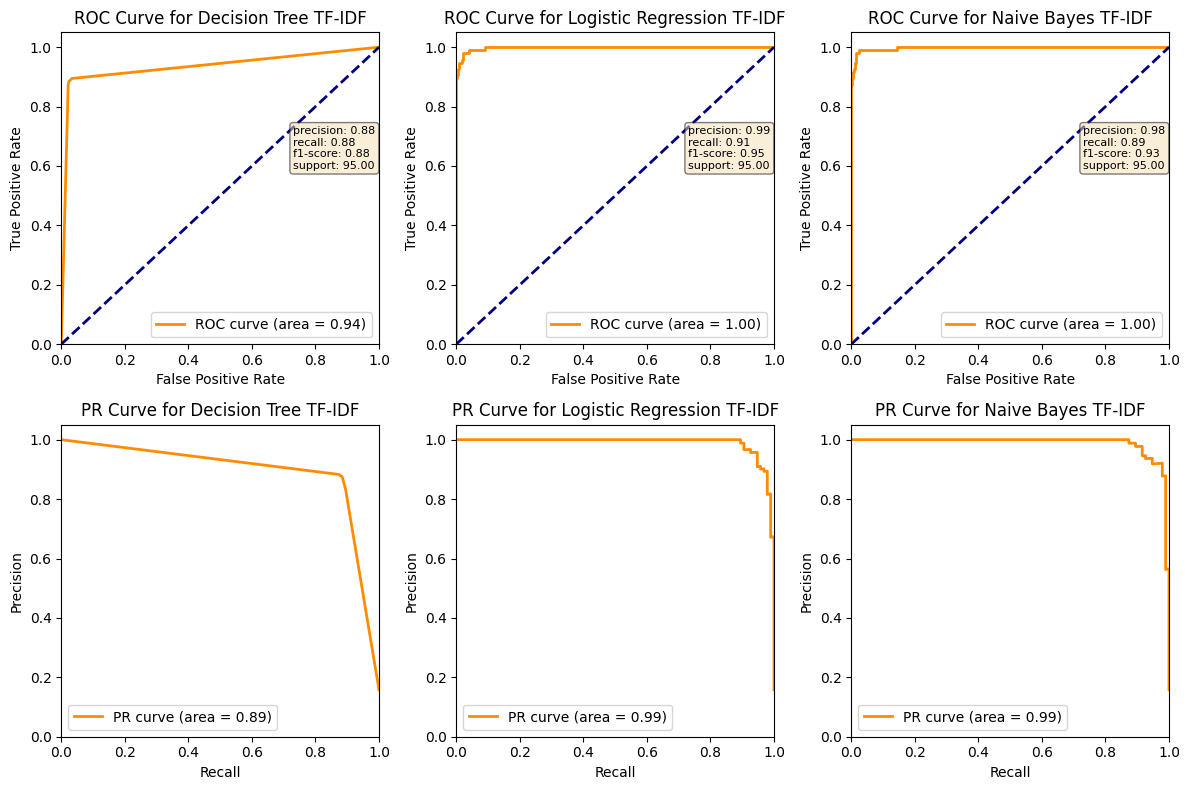

In [81]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

plot_roc_pr_curves(best_decision_tree_tfidf, X_test, y_test, "Decision Tree TF-IDF", ax[:, 0])
plot_roc_pr_curves(best_logistic_regression_tfidf, X_test, y_test, "Logistic Regression TF-IDF", ax[:, 1])
plot_roc_pr_curves(best_naive_bayes_tfidf, X_test, y_test, "Naive Bayes TF-IDF", ax[:, 2])

plt.tight_layout()
plt.show()